# Heart failure prediction 

<center>
<img src="https://images.theconversation.com/files/435609/original/file-20211203-15-1eux98t.jpg?ixlib=rb-1.1.0&rect=0%2C17%2C3894%2C2673&q=45&auto=format&w=600&fit=clip">    
</center>


### Goal

Creating a model to predict if a patient has heart disease or not.

### Data dictionary

**Age:** age of the patient [years]

**Sex**: sex of the patient [M: Male, F: Female]

**ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

**RestingBP**: resting blood pressure [mm Hg]

**Cholesterol**: serum cholesterol [mm/dl]

**FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

**RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

**MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]

**ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]

**Oldpeak**: oldpeak = ST [Numeric value measured in depression]

**ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

**HeartDisease**: output class [1: heart disease, 0: Normal]


<h1> Libraries </h1>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from scipy import stats
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import lightgbm as lgb


import plotly.express as px
import plotly.graph_objects as go

sns.set()

# Loading dataset

In [2]:
df = pd.read_csv('../input/heart-failure-prediction/heart.csv')

# Exploratory data analysis  

## Heart disease - Gender

In [3]:
df_v=df.copy()
df_v['HeartDisease']=df_v['HeartDisease'].map({1:'HeartDisease',0:'No HeartDisease'})
df_v['Sex']=df_v['Sex'].map({'M':'Male','F':'Female'})
fig = px.sunburst(df_v, path=['Sex', 'HeartDisease'] ,color='HeartDisease',
                    color_discrete_map={'(?)':'black', 'HeartDisease':'Red', 'No HeartDisease':'Green'},
                    title='Heart disease - Gender')
fig.show()

### In this dataset, men are more likely to have heart disease

## The effect of age

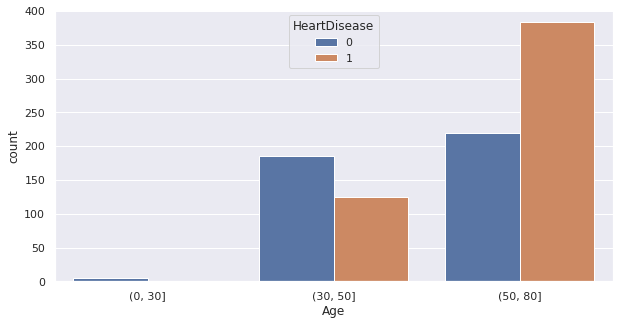

In [4]:
plt.figure(figsize=(10,5))
bins=[0,30,50,80]
sns.countplot(x=pd.cut(df.Age,bins=bins),hue=df.HeartDisease)
plt.show()

### Adults age 50 and older are more likely than younger people to have heart disease

## Chest pain type


Chest pain type : 

**TA**: Typical Angina, **ATA**: Atypical Angina, **NAP**: Non-Anginal Pain, **ASY**: Asymptomatic

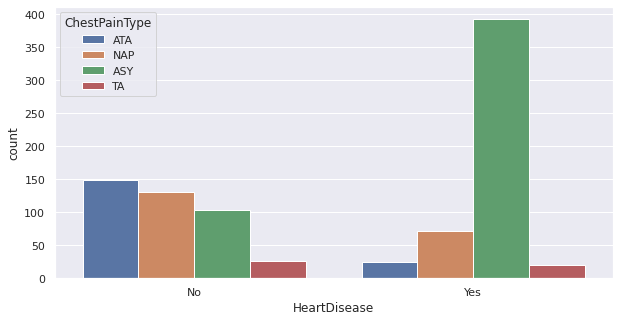

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(x=df.HeartDisease,hue=df.ChestPainType)
plt.xticks(np.arange(2), ['No', 'Yes']) 
plt.show()

### Asymptomatic is the most common type of chest pain among patients with heart disease

## RestingECG
RestingECG : Resting electrocardiogram results

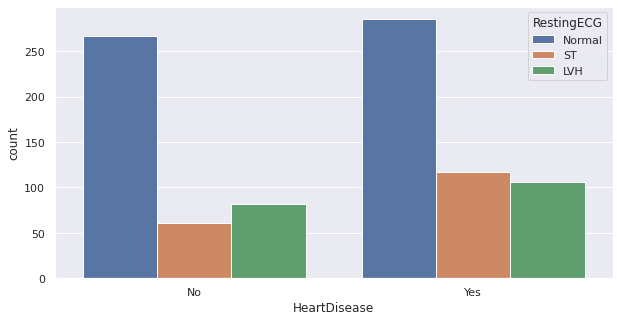

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(x=df.HeartDisease,hue=df.RestingECG)
plt.xticks(np.arange(2), ['No', 'Yes']) 
plt.show()

## ST_Slope
The slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

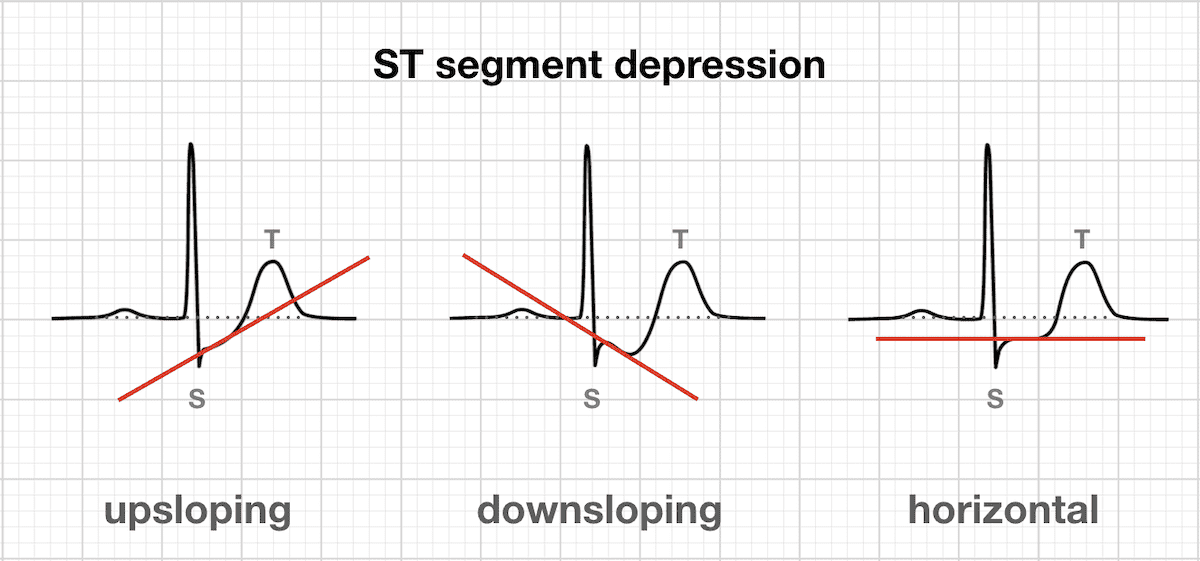

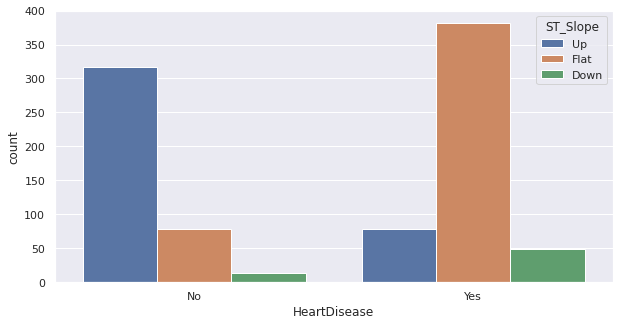

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(x=df.HeartDisease,hue=df.ST_Slope)
plt.xticks(np.arange(2), ['No', 'Yes']) 
plt.show()

### Flat is the most common type of st_slop among patients with heart disease

## ExerciseAngina
Exercise-induced angina

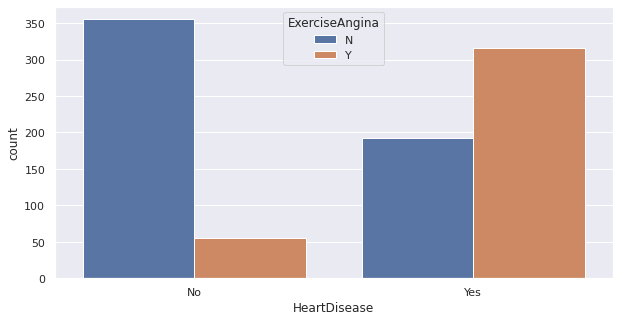

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(x=df.HeartDisease,hue=df.ExerciseAngina)
plt.xticks(np.arange(2), ['No', 'Yes']) 
plt.show()

## Visualizing numeric features 

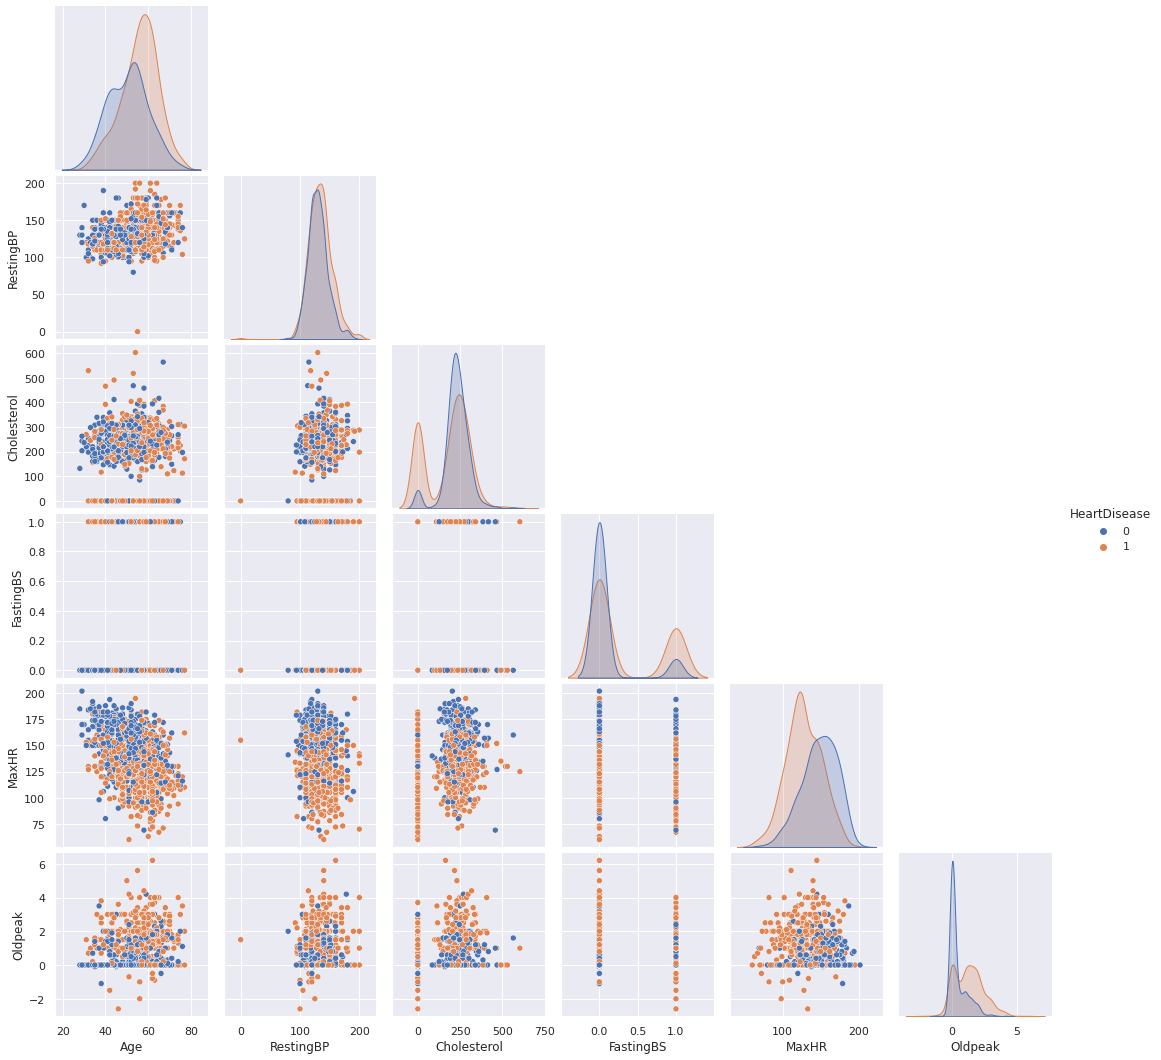

In [9]:
sns.pairplot(df,hue='HeartDisease',corner=True)

### Remove outliers

In [10]:
df.drop(df[df.RestingBP<50].index,axis=0,inplace=True)

# Correlations

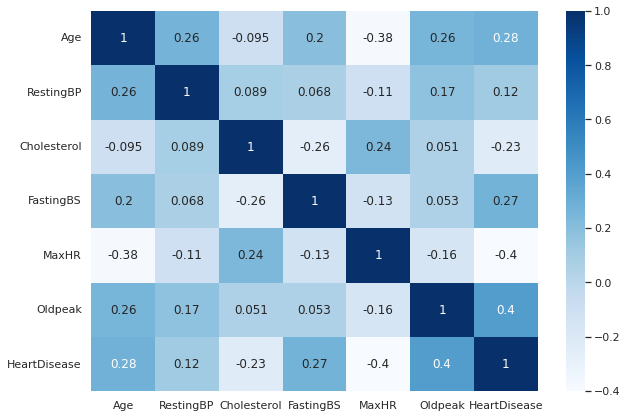

In [11]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True,cmap='Blues')
plt.show()

# Modeling

In [12]:
#Get dummies
df_e=pd.get_dummies(df)

#Define inputs & Output
X=df_e.drop(['HeartDisease'],axis=1)
y=df_e['HeartDisease']

#Normalize
scaler=StandardScaler()
X=scaler.fit_transform(X)

#Split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

## Parameter Tuning

In [13]:
#Param grid
parameters = {'n_estimators':[10,15,16,18,20,25,40,50,180,200],
              'max_depth':[5,7,8,9,10,12,15,16,18,19],
             #'min_samples_split':[2,3,5,8],
             #'min_samples_leaf':[2,3,5,8],
             }

#Define grid search
clf = GridSearchCV(RandomForestClassifier(), parameters)

#Fit and get tuned params
#clf.fit(X,y)
#clf.best_params_

## CV function

In [14]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return np.mean(scores)

In [15]:
scores=[]
cv_scores=[]
models_name=['LogisticRegression','RandomForest','SVC','CatBoost','LGBM']

## Logistic Regression

In [16]:
Model_LR=LogisticRegression(solver='liblinear')

#Fit and predict
Model_LR.fit(X_train,y_train)
y_pred=Model_LR.predict(X_test)

#Get scores
scores.append(accuracy_score(y_pred,y_test))
cv_scores.append(evaluate_model(Model_LR,X,y))

In [17]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       114
           1       0.90      0.94      0.92       162

    accuracy                           0.90       276
   macro avg       0.90      0.89      0.90       276
weighted avg       0.90      0.90      0.90       276



## Random Forest Classifier

In [18]:
Model_RF=RandomForestClassifier(n_estimators=200,max_depth=5,
                                min_samples_split=2,min_samples_leaf=2,
                                criterion='entropy')

#Fit and predict
Model_RF.fit(X_train,y_train)
y_pred=Model_RF.predict(X_test)

#Get scores
scores.append(accuracy_score(y_pred,y_test))
cv_scores.append(evaluate_model(Model_RF,X,y))

In [19]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       111
           1       0.89      0.92      0.90       165

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



## SVC (C-Support Vector)

In [20]:
Model_SVC=SVC(gamma='scale')

#Fit and predict
Model_SVC.fit(X_train,y_train)
y_pred=Model_SVC.predict(X_test)

#Get scores
scores.append(accuracy_score(y_pred,y_test))
cv_scores.append(evaluate_model(Model_SVC,X,y))

In [21]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       112
           1       0.89      0.91      0.90       164

    accuracy                           0.88       276
   macro avg       0.88      0.87      0.88       276
weighted avg       0.88      0.88      0.88       276



## CatBoost Classifier

In [22]:
Model_CatBoost=CatBoostClassifier(verbose=False)
#Fit and predict
Model_CatBoost.fit(X_train,y_train,eval_set=(X_test, y_test))
y_pred=Model_CatBoost.predict(X_test)

#Get scores
scores.append(accuracy_score(y_pred,y_test))
cv_scores.append(evaluate_model(Model_CatBoost,X,y))

In [23]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       107
           1       0.91      0.91      0.91       169

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



## LGBM Classifier

In [24]:
Model_lgb=lgb.LGBMClassifier()

#Fit and predict
Model_lgb.fit(X_train,y_train)
y_pred=Model_lgb.predict(X_test)

#Get scores
scores.append(accuracy_score(y_pred,y_test))
cv_scores.append(evaluate_model(Model_lgb,X,y))

In [25]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       112
           1       0.89      0.92      0.91       164

    accuracy                           0.89       276
   macro avg       0.89      0.88      0.88       276
weighted avg       0.89      0.89      0.89       276



## Classification Results

In [26]:
pd.DataFrame({'Model':models_name,'Validation Score':scores,'Cross_Validation Score':cv_scores}).style.background_gradient()

,Model,Validation Score,Cross_Validation Score
0,LogisticRegression,0.902174,0.864800
1,RandomForest,0.884058,0.871113
2,SVC,0.880435,0.865217
3,CatBoost,0.884058,0.879843
4,LGBM,0.887681,0.867856


## CatBoost Feature importance

Text(0.5, 1.0, 'Feature Importance')

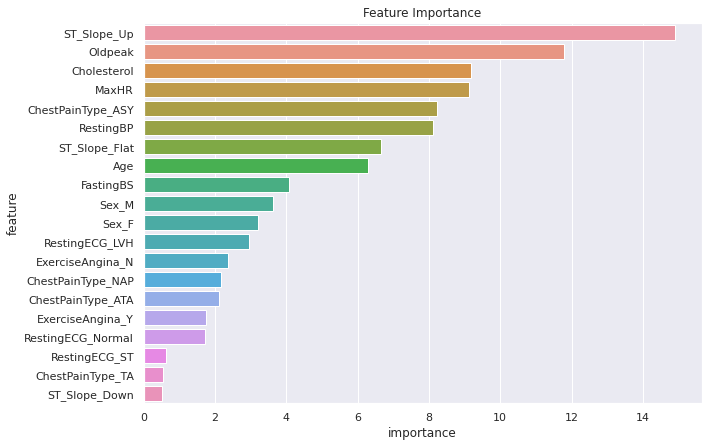

In [27]:
tmp=pd.DataFrame({'feature':df_e.drop('HeartDisease',axis=1).columns,
                 'importance':Model_CatBoost.feature_importances_}).sort_values(by='importance',ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(x=tmp.importance ,y=tmp.feature).set_title('Feature Importance')